# HUGS - HUb for Greenhouse gas data Science

## Overview

HUGS works in a modular way without a fixed hierarchical structure. 

There are multiple modules

* Datasources
* Instrument
* Sites
* Networks

For example they can be arranged as

* Network
    * Site
        * Instrument
            * Datasource
            * Datasource
            * Datasource

Or
            

* Network
    * Datasource
    * Datasource
    * Datasource

There is no set fixed hierarchy for these modules
        




Data is stored within objects and these objects may hold links to data in the object store.

In the following code we will read in a data file, analyse the data contained within it, segment the data into sections which can be easily stored in the object store and then recombine these dataframes ready for export to the end user.

In [29]:
# Suppress some Pandas warnings - these will be fixed
import warnings
warnings.filterwarnings('ignore')
# Data pretty printer for nicer printing of data
import pprint
# User PrettyPrinter to print them in a nicer way
pp = pprint.PrettyPrinter(indent=2)

In [30]:
# For listing of objects in the object store
from objectstore.hugs_objstore import list_object_names
# To get the local bucket (a container for data in the object store)
from objectstore.local_bucket import get_local_bucket
# The object to process and store CRDS data
from processing._crds import CRDS

## Processing data

Here we read in a data file from the Bilsdale site using the read_file() function from the CRDS class

This function
* Creates a CRDS object
* Collects metadata
* Splits the data into separate dataframes for each gas
* Creates a Datasource object for the gas, holding data and metadata
* Stores this data within the CRDS object



In [31]:
filename = "data/bsd.picarro.1minute.248m.dat"

In [32]:
crds = CRDS.read_file(filename)

We can now check the daterange for the data read in

In [33]:
crds.get_daterange()

(Timestamp('2014-01-30 10:52:30'), Timestamp('2014-01-30 14:20:30'))

To check that the function has processed the datafile correctly and picked up the right dates I've used the Linux `head` and `tail` applications to get the first and last rows (not containing NaNs) from the data file.

Head

`140130 105230       air    8   1960.24   0.236    26    409.66   0.028    26    204.62   6.232    26`

Tail

`140130 142030       air    8   1952.24   0.674    25    408.78   0.019    25    196.35   6.879    25`


We can view some of the data stored in each Datasource within this CRDS object

In [34]:
datasources = crds.get_datasources()

for d in datasources:
    data = d.get_data()
    # Print the top two lines of each dataframe
    print("\n", data.head(2))


              Datetime  ch4 count  ch4 stdev  ch4 n_meas
0 2014-01-30 10:52:30    1960.24      0.236        26.0
1 2014-01-30 10:53:30    1959.31      0.502        26.0

              Datetime  co2 count  co2 stdev  co2 n_meas
0 2014-01-30 10:52:30     409.66      0.028        26.0
1 2014-01-30 10:53:30     409.50      0.058        26.0

              Datetime  co count  co stdev  co n_meas
0 2014-01-30 10:52:30    204.62     6.232       26.0
1 2014-01-30 10:53:30    200.78     5.934       26.0


## Metadata

We can also check the metadata collected. This is stored within a Metadata object within the CRDS object and we can now view this.

In [35]:
metadata = crds.get_metadata()
pp.pprint(metadata)


{ 'end_datetime': '2014-01-30T14:20:30',
  'height': '248m',
  'instrument': 'picarro',
  'port': '8',
  'resolution': '1m',
  'site': 'bsd',
  'start_datetime': '2014-01-30T10:49:30',
  'type': 'air'}


## Visualisation

We can now visualize some of this data



<IPython.core.display.Javascript object>


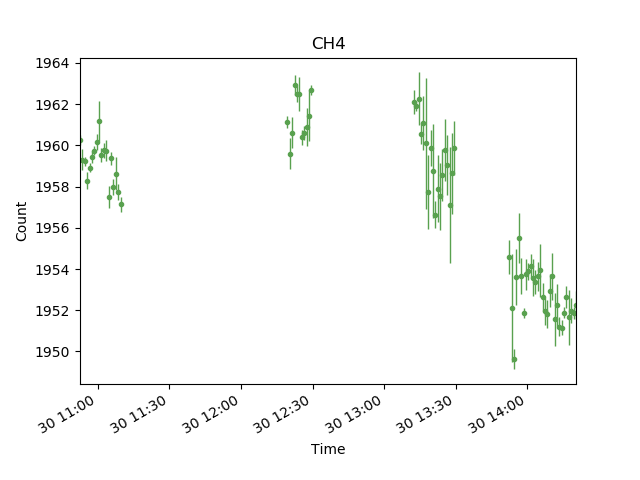

<IPython.core.display.Javascript object>


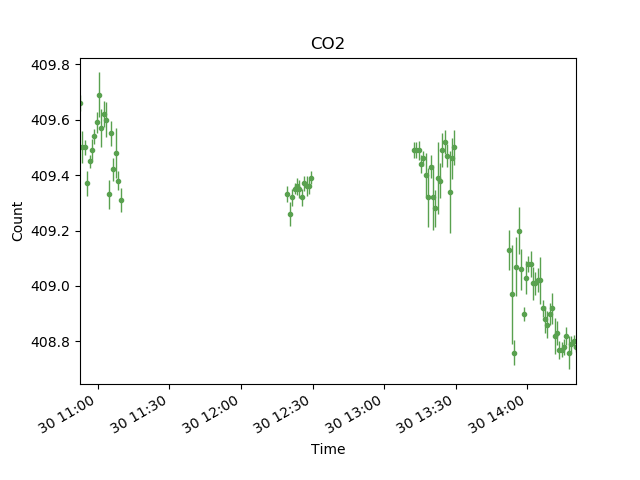

<IPython.core.display.Javascript object>


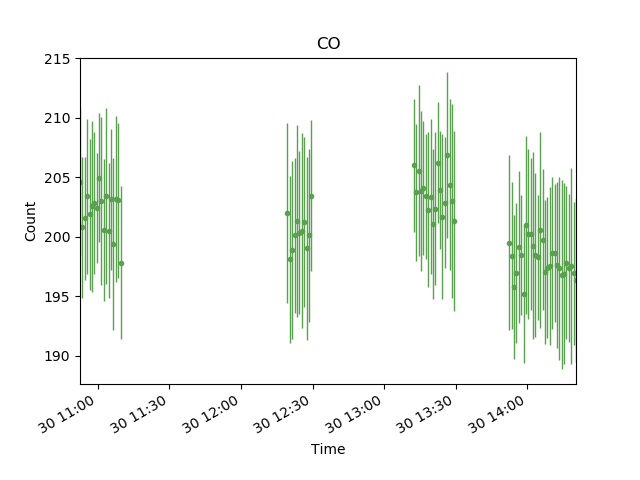

In [36]:
%matplotlib notebook

# Get the first datasource
datasource = datasources[0]
for datasource in datasources:
    data = datasource.get_data()
    # Get column names
    col_names = list(data.columns)
    ax = data.plot(x="Datetime", y=col_names[1], elinewidth=1, linewidth=0, marker="o", markersize=3, 
                   yerr=col_names[2], legend=None, color="#59a14f", title=datasource._name.upper())
    ax.set(xlabel="Time", ylabel="Count")




## Object Store

The processed and segmented data is now ready to be stored in the object store.

The data for each gas is stored within a Pandas DataFrame that gets converted into a compressed binary HDF5 file format similar to that used by NetCDF. Each datasource stores its data with a key containing its own universally unique identifier (UUID).

Each object has a .save() function that saves the object to the data store


In [37]:
# Get a bucket, a container used to store data in the object store
bucket = get_local_bucket()
# Save the object to the object store
crds.save(bucket)

The code for this save function is given below

```py
def save(self, bucket=None):
    """ Save the object to the object store

        Args:
            bucket (dict, default=None): Bucket for data
        Returns:
            None
    """
    if self.is_null():
        return

    # If a bucket isn't passed, get the hugs bucket
    if bucket is None:
        bucket = _get_bucket()
    
    # Create the key at which to store this object
    crds_key = "%s/uuid/%s" % (CRDS._crds_root, self._uuid)
    
    # Get the datasources to save themselves to the object store
    for d in self._datasources:
        d.save(bucket)
    
    # Save this object as JSON
    _ObjectStore.set_object_from_json(bucket=bucket, key=crds_key, data=self.to_data())
```

This function then saves the CRDS object and each of its Datasources to the object store. 
As each Datasource holds gas data this in turn is saved by the save function of each Datasource.

We can now view the structure of the object store by querying the keys in the bucket

In [39]:
# List all the objects in the container
bucket_list = list_object_names(bucket)

pp.pprint(bucket_list)


[ 'datasource/uuid/fbd61135-1a26-442b-89a4-14c3e7ff155f',
  'datasource/uuid/475b95fb-9d9b-4950-aef4-805d6b281e62',
  'datasource/uuid/f3130960-0f40-4ccb-8094-93c4b5843eec',
  'datasource/uuid/d6966ead-e5ec-4a69-ac81-b6dc54047426',
  'datasource/uuid/0f8e9232-d3eb-4e34-b1ca-1d536ae72723',
  'datasource/uuid/7806a087-cce3-4150-93a0-76a4ac8f7d6d',
  'datasource/uuid/7da42dfa-84a2-434a-ad10-3fb9295e603b',
  'datasource/uuid/caa63ce1-91a7-4f58-80af-ed5c66f15f67',
  'datasource/uuid/338672a3-30c4-4655-b0f2-d05521d25ef2',
  'CRDS/uuid/d131152b-7ece-4204-bfcb-212f36e6e754',
  'CRDS/uuid/102f37a1-b7c7-40b3-8e50-5ddc6ab7580e',
  'CRDS/uuid/909973de-ce20-4715-b8df-fca64861c95a',
  'data/uuid/338672a3-30c4-4655-b0f2-d05521d25ef2/2014-01-30T10:52:30_2014-01-30T14:20:30',
  'data/uuid/475b95fb-9d9b-4950-aef4-805d6b281e62/2014-01-30T10:52:30_2014-01-30T14:20:30',
  'data/uuid/f3130960-0f40-4ccb-8094-93c4b5843eec/2014-01-30T10:52:30_2014-01-30T14:20:30',
  'data/uuid/7806a087-cce3-4150-93a0-76a4ac8f7

### Keys

Each object in the object store is saved at a key. This allows each object to be stored at a unique location.

Objects are stored as so

`{object_name}/uuid/{uuid}`

Some objects can also be accessed by name through their name key

`{object_name}/name/{name}/{uuid}`

This allows lookup of object UUID by their name

## Searching for data

We can look for data in the object store by date

In [40]:
from processing._crds import CRDS

# Get the search start date
# As this datafile only has data for a single day we just use the same start and end datetime
start = CRDS.to_datetime("2014-01-30")
end =  start

object_type = "datasource"
# We can now search the object store for keys
keys = crds.search_store(bucket=bucket, root_path=object_type, datetime_begin=start, datetime_end=end)

pp.pprint(keys)

[ '7da42dfa-84a2-434a-ad10-3fb9295e603b',
  'd6966ead-e5ec-4a69-ac81-b6dc54047426',
  '7806a087-cce3-4150-93a0-76a4ac8f7d6d']


These are the keys for data in the object store that holds data between those dates. Currently as datafiles are not large they are not being split into week/month segments depending on the resolution of the readings. This feature will be implemented soon.

Now that we have the keys for the Datasources containing this data we can recombine these pieces into a single 
dataframe. Here we will choose to use all three.

Functions to select and order data within the produced dataframe will be implemented.


In [48]:
from processing._recombination import get_sections

# Get the data at each of the found keys
datasources = get_sections(bucket, keys)

print(datasources)

[<modules._datasource.Datasource object at 0x7fb1cf842a58>, <modules._datasource.Datasource object at 0x7fb1cf842ba8>, <modules._datasource.Datasource object at 0x7fb1cf8521d0>]


In [49]:
dataframes = [datasource.get_data() for datasource in datasources]

for d in dataframes:
    print("\n",d.head(2))


              Datetime  ch4 count  ch4 stdev  ch4 n_meas
0 2014-01-30 10:52:30    1960.24      0.236        26.0
1 2014-01-30 10:53:30    1959.31      0.502        26.0

              Datetime  co2 count  co2 stdev  co2 n_meas
0 2014-01-30 10:52:30     409.66      0.028        26.0
1 2014-01-30 10:53:30     409.50      0.058        26.0

              Datetime  co count  co stdev  co n_meas
0 2014-01-30 10:52:30    204.62     6.232       26.0
1 2014-01-30 10:53:30    200.78     5.934       26.0


In [50]:
from processing._recombination import combine_sections

# Combine each of the sections into a single dataframe
combined = combine_sections(dataframes)

print(combined)

              Datetime  ch4 count  ch4 stdev  ch4 n_meas  co2 count  \
0  2014-01-30 10:52:30    1960.24      0.236        26.0     409.66   
1  2014-01-30 10:53:30    1959.31      0.502        26.0     409.50   
2  2014-01-30 10:54:30    1959.23      0.216        25.0     409.50   
3  2014-01-30 10:55:30    1958.28      0.420        26.0     409.37   
4  2014-01-30 10:56:30    1958.91      0.224        25.0     409.45   
5  2014-01-30 10:57:30    1959.42      0.292        26.0     409.49   
6  2014-01-30 10:58:30    1959.74      0.214        26.0     409.54   
7  2014-01-30 10:59:30    1960.15      0.391        25.0     409.59   
8  2014-01-30 11:00:30    1961.16      0.969        26.0     409.69   
9  2014-01-30 11:01:30    1959.52      0.335        25.0     409.57   
10 2014-01-30 11:02:30    1959.75      0.356        26.0     409.62   
11 2014-01-30 11:03:30    1959.74      0.522        26.0     409.60   
12 2014-01-30 11:04:30    1957.48      0.542        25.0     409.33   
13 201

We can now have a look at this data again and make sure it comes out correctly

In [51]:
col_names = list(combined.columns)

print(col_names)

['Datetime', 'ch4 count', 'ch4 stdev', 'ch4 n_meas', 'co2 count', 'co2 stdev', 'co2 n_meas', 'co count', 'co stdev', 'co n_meas']


<IPython.core.display.Javascript object>


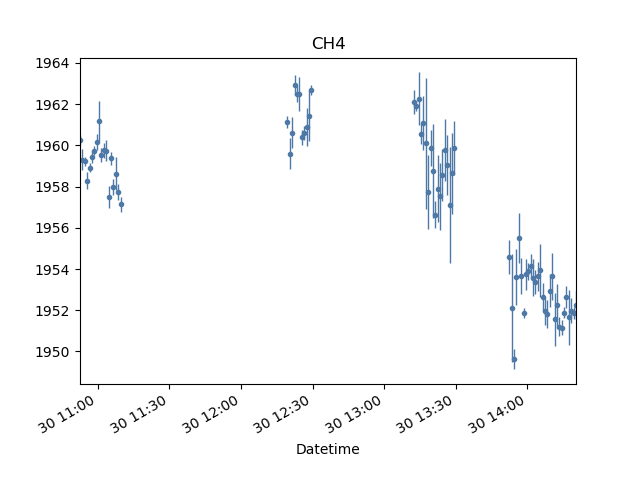

<IPython.core.display.Javascript object>


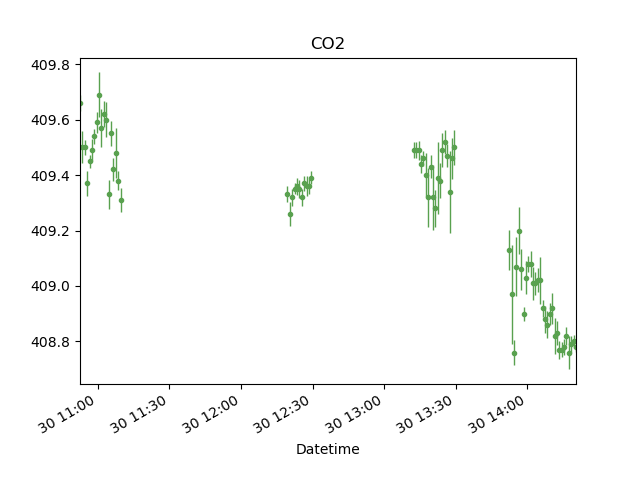

<IPython.core.display.Javascript object>


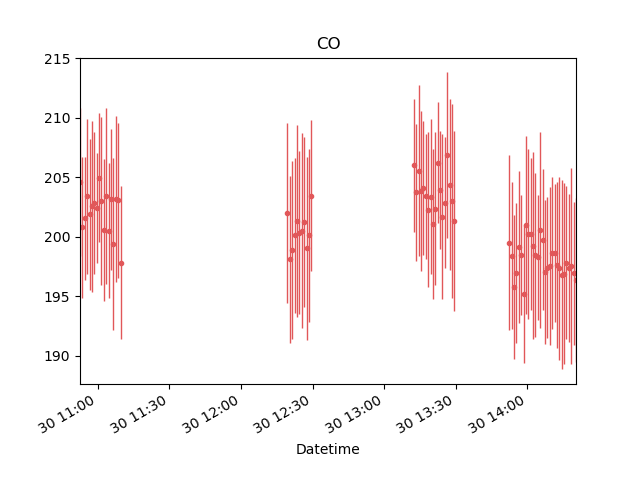

In [52]:
ax = combined.plot(x="Datetime", y="ch4 count", elinewidth=1, linewidth=0, marker="o", markersize=3, 
               yerr="ch4 stdev", legend=None, color="#4e79a7", title="CH4")

ax = combined.plot(x="Datetime", y="co2 count", elinewidth=1, linewidth=0, marker="o", markersize=3, 
               yerr="co2 stdev", legend=None, color="#59a14f", title="CO2")

ax = combined.plot(x="Datetime", y="co count", elinewidth=1, linewidth=0, marker="o", markersize=3, 
               yerr="co stdev", legend=None, color="#e15759", title="CO")

We've now seen data being read into the object store, processed, metadata extracted and then recombined from the object store.